In [1]:
import py21cmsense as p21s
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from astropy import units

# . Compute \(uv\) coordinates¶
The important thing to remember here is that the \(uv\) coordinates of the baselines are frequency-dependent. For a tracking telescope (where the phase centre changes over time so that it keeps pointing at the same source in the sky), they also depend on time (i.e. the baselines “look different” to the source as it moves overhead).

Let’s take a simple HERA-like telescope as our model. We can create such an array with 21cmSense:



In [6]:
hera_layout = p21s.antpos.hera(
    hex_num=11,         # number of antennas along a side
    separation=14*units.m,  # separation between antennas (in metres)
    dl=12.12*units.m        # separation between rows
)

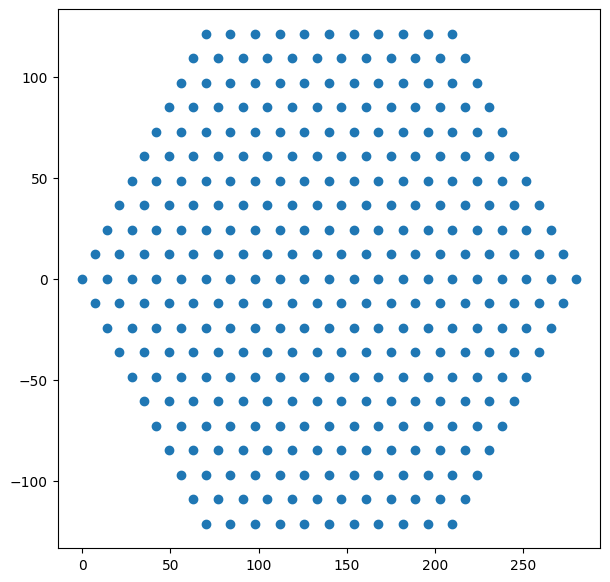

In [7]:
plt.figure(figsize=(7,7))
plt.scatter(hera_layout[:,0], hera_layout[:,1]);

So far, we have the antennas, but not the \(uv\) positions. We could of course compute them from the array, but let’s use the in-built functionality of 21cmSense to do this.

The way to do it is to create an Observatory object, but to do this, we must also specify some extra information about the antennas themselves, in particular, their beam.

We won’t actually use the beam to do anything until the next step (2), but let’s go ahead and define one. Note that 21cmSense doesn’t do anything very interesting with the beam (you’ll notice that none of the steps use the exact beam shape per se, just bulk properties of it). We’ll use an in-built Gaussian primary beam for each baseline, that has a width that depends on the frequency:

In [8]:
beam = p21s.beam.GaussianBeam(
    frequency = 150.0 * units.MHz,  # just a reference frequency
    dish_size = 14 * units.m
)

With that, we can construct the observatory:

In [9]:
hera = p21s.Observatory(
    antpos = hera_layout,
    beam = beam,
    latitude = 0.536189 * units.radian,
    Trcv = 100*units.K
)

With that, we can determine the baseline lengths themselves:

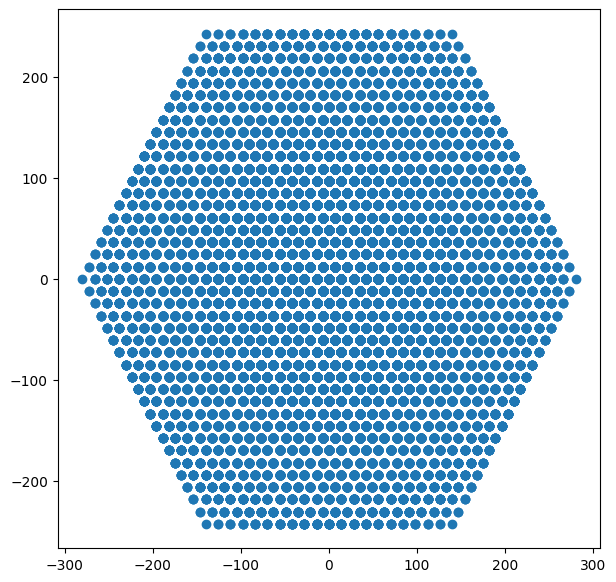

In [10]:
plt.figure(figsize=(7,7))
plt.scatter(
    hera.baselines_metres[..., 0].flatten(),
    hera.baselines_metres[..., 1].flatten()
);

Since HERA has a lot of redundant baselines, it’s helpful to visualise how many baselines actually sit at each of these locations:

In [13]:
red_groups = hera.get_redundant_baselines()
red_grp_coords = hera.baseline_coords_from_groups(red_groups)
weights = hera.baseline_weights_from_groups(red_groups)

finding redundancies: 100%|█████████████████████████████████████████████████████████████████████████████████| 330/330 [00:00<00:00, 446.52ants/s]


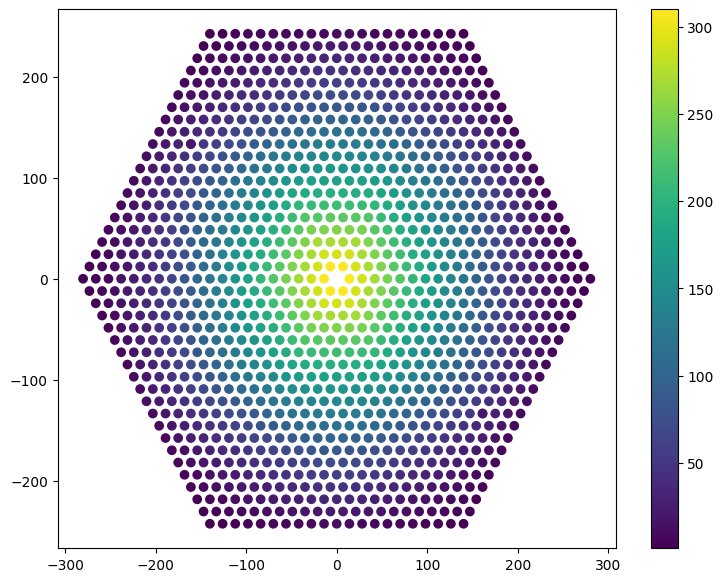

In [14]:
plt.figure(figsize=(9,7))
plt.scatter(red_grp_coords[:,0], red_grp_coords[:,1], c=weights)
plt.colorbar();

How many redundant groups are there?

In [15]:
print(len(red_groups))

1262


Compared to how many baselines?

In [16]:
len(hera.antpos)**2 - len(hera.antpos)

109230

Note that we still haven’t actually computed the \(uv\) coordinates of all the baselines, and we won’t here because it’s frequency and time dependent. We’ll get to that in a later step.

# 2. Construct a \(uv\) grid¶
Why do we have to construct a \(uv\) grid? Why not just use the actual \(uv\) values of each baseline directly?

The simple answer is that the cosmological power spectrum is naturally defined as a function of spatial wavenumber \(k\) (which is the Fourier dual of comoving distance, \(x\)), and \(k_{\perp}\) is directly proportional to \(uv\), while \(k_{||}\) is directly proportional to \(\eta\) (the Fourier dual of frequency). Thus, the cosmological power spectrum would be naturally defined by the Fourier transform of a particular baseline, sitting at some \(uv\), over frequency, but only if that baseline stayed at the same :math:`uv` coordinate at all frequencies. This is not true, and so we have to have some way of defining what we expect the measurement to be at a particular \(uv\) across frequency. This must involve something like binning (or interpolation).

Why does the recipe specify that the \(uv\) grid should have cells with “roughly” the same width as \(\tilde{A}_p\)? Well, think about the visibility equation:

\[V \approx \int A(\mathbf{\hat{r}}) T(\mathbf{\hat{r}}) e^{-2\pi i \mathbf{u}\cdot\mathbf{r}} d\Omega.\]
Ignoring subtleties of sky curvature and the horizon, this is essentially a Fourier transform, so that the convolution theorem applies:

\[V \approx \tilde{A}(\mathbf{u} - \mathbf{u}_0) \star \tilde{T}(\mathbf{u}).\]
This implies that the antenna “sees” in the \(uv\)-plane not just at its exact \(uv\) position, but a weighted sum of inputs, equivalent to \(\tilde{A}(\mathbf{u})\). Given that \(A(r)\) is typically a compact(ish) dome-like (Gaussianish) function, \(\tilde{A}(\mathbf{u})\) should also be one, with width inversely proportional to the beam width.

Now, imagine we create a \(uv\) grid where the cells are much smaller than the “width” of \(\tilde{A}_p\). Then each baseline really “sees” stuff from a number of cells, with different weight. Not only does this mean that evaluating the amount of noise in each cell becomes more difficult, it also means that the noise value in one cell becomes correlated with the surrounding cells (since the same baseline contributes to evaluating each of them). This makes all the calculations harder.

On the other hand, if the \(uv\) grid has cells that are much larger than the width of \(\tilde{A}_p\), we lose resolution. Cells that are close to the width of \(\tilde{A}_p\) ensure that correlations between neighbouring cells are minimal (and thus we ignore them…) and we get the maximum resolution that we can achieve.

21cmSense calculates this width for us in units of wavelength (nominally defined at the reference frequency, which we defined as part of the GaussianBeam):



In [17]:
beam.uv_resolution

7.004845999161192

And it also generates a \(uv\) grid:

In [18]:
ugrid = hera.ugrid()

In [19]:
ugrid.min(), ugrid.shape

(-140.09691998322387, (41,))

The recipe calls for a three-dimensional grid, \(uv\eta\). To define the \(\eta\) part of the grid, we require information about the bandwidth of the observation. Note that this bandwidth is that bandwidth going into a particular power spectrum estimation, not necessarily the full bandwidth of the instrument itself. Typically the bandwidth will be less than about 20 MHz, because of the concern of the Lightcone Effect.

Since most instruments have regularly spaced frequency channels, the \(\eta\) grid is effectively the Fourier dual of the frequency channels.

To obtain this, we need more than just an Obervatory, we need an Observation (i.e. a strategy with which to observe with the observatory…). We set this up now, noting that there are quite a few more parameters that go into defining an Observation that we’re ignoring here (they have sensible defaults, and we’ll see what they do later):

In [20]:
observation = p21s.Observation(
    observatory = hera,
    n_channels=80,
    bandwidth=8 * units.MHz,
)

We can now get the \(\eta\) grid:

In [21]:
observation.eta

<Quantity [ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
            1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,
            2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,  2.875,
            3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,  3.75 ,  3.875,
            4.   ,  4.125,  4.25 ,  4.375,  4.5  ,  4.625,  4.75 ,  4.875,
           -5.   , -4.875, -4.75 , -4.625, -4.5  , -4.375, -4.25 , -4.125,
           -4.   , -3.875, -3.75 , -3.625, -3.5  , -3.375, -3.25 , -3.125,
           -3.   , -2.875, -2.75 , -2.625, -2.5  , -2.375, -2.25 , -2.125,
           -2.   , -1.875, -1.75 , -1.625, -1.5  , -1.375, -1.25 , -1.125,
           -1.   , -0.875, -0.75 , -0.625, -0.5  , -0.375, -0.25 , -0.125] 1 / MHz>

# 3. Simulate movement of baselines¶

Simulate the movement of baselines through the \(uv\) cells over a sidereal day of observations (or over however much time the telescope is being operated per sidereal day). Record how much time \(t_u\) each baseline spends in each \(uv\) cell.

There’s some subtlety here.

The main point is that within a certain “small” amount of time, the telescope is essentially measuring the same sky over and over again for each snapshot visibility it measures. The amount of time it integrates for a particular visibility snapshot is called the integration time, and since the thermal noise on the visibility is averaged over all this time, the total noise goes down linearly with this amount of time.

But who’s to say we couldn’t have joined the next snapshot into this one? If it’s essentially the same sky, we could average it together as well. The subtlety comes about because in detail it depends on if you’re tracking a point on the sky, or letting it drift overhead. For a drift-scan telescope (like HERA) the amount of time you could average together depends on the size of the beam: if the sky has rotated enough that everything that was in the beam is now out of it, you’re essentially taking an independent observation, and you can’t average that in visibility space (only in power spectrum space). By default, 21cmSense will assume that you’d average together observations for as long as it takes to get throug the FWHM of the beam:

In [23]:
beam.fwhm * 180/np.pi

<Quantity 8.64976715 rad>

In [24]:
observation.obs_duration

<Quantity 0.02402713 d>

Of course, you can change this manually if you want to!

But it gets a little more complicated. Within that time-window, while you’re essentially seeing the same thing, you’re not actually measuring the same thing with a particular baseline. Averaging the values for that baseline together over the time will cause the visibility to decohere. Instead, you can think about tracking the observation within that time window, so that the sky seems to stay constant, but the projected baseline lengths change. This way, the same point on the \(uv\) grid will always get the same measurement (at least, roughly), but the baselines contributing to this \(uv\) cell will change.

This is why we have to measure how much time each baseline spends in each \(uv\) cell – they move with time. Ideally, we can average down the noise linearly with the amount of total time spent by all baselines in a particular cell. You can also specify that you don’t want to average the visibilities together this way (instead you can just average power spectra over time), but lets for now assume the coherent assumption:

In [26]:
observation = observation.clone(
    coherent=True,
    integration_time=60*units.s
)

We can generate a map of how many baselines were in each \(uv\) cell over a single observation duration:

In [28]:
observation.uv_coverage

gridding baselines: 100%|██████████████████████████████████████████████████████████████████████████| 1262/1262 [00:00<00:00, 26091.26baselines/s]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

We can generate a map of how many baselines were in each \(uv\) cell over a single observation duration:

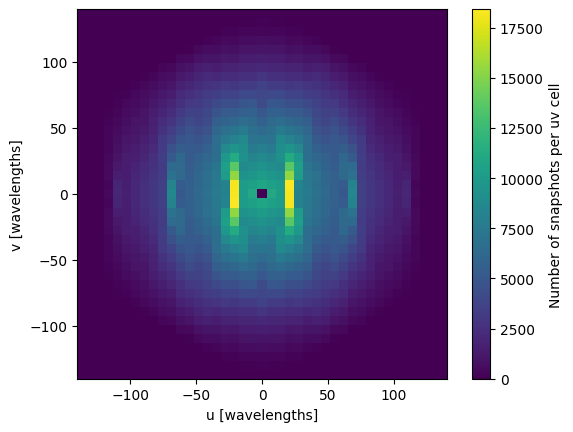

In [29]:
plt.imshow(observation.uv_coverage, extent=(observation.ugrid.min(), observation.ugrid.max())*2)
ax = plt.colorbar()
ax.set_label("Number of snapshots per uv cell")
plt.xlabel('u [wavelengths]')
plt.ylabel('v [wavelengths]');

# 4. Obtain Noise Per Day Per Cell¶
Now that we know how much total time is spent by baselines per \(uv\)-cell, we can calculate the thermal noise on a power spectrum estimate in that cell. Note that the thermal noise is constant with respect to \(\eta\).

To do this, we use a Sensitivity class. These classes do sensitivity calculations of various output statistics that might be computed by an Observation. In this case, we are interested in the PowerSpectrum sensitivity:

In [30]:
sensitivity = p21s.PowerSpectrum(
    observation=observation
)

This class has a simple method that calculates the thermal noise, according the equation given as part of this step. The key here is that \(T_{\rm sys}\) is the system temperature, which is essentially the temperature of the sky plus the temperature of the instrument. These belong to the observation:

In [31]:
observation.tsky_amplitude.to('K')

<Quantity 260. K>

In [32]:
observation.tsky_ref_freq

<Quantity 150. MHz>

In [33]:
observation.spectral_index

2.6

The thermal noise equation given by the equation is for \(P(k)\), but 21cmSense works with \(\Delta^2(k) = k^3P(k)/2\pi^2\), which thus depends on the scale, \(k\). Here, we’ll show the result without dividing by the time for which baselines occupy the cell:

In [38]:
import astropy.cosmology.units as cu # Check carefully
sensitivity.thermal_noise(k_perp=0.1* cu.littleh / units.Mpc, k_par=0.1 * cu.littleh / units.Mpc, trms=observation.Tsys)

<Quantity 3.52200308e+15 mK2>

# 5. Average over days¶
Since the sky repeats every day, we can average days together coherently. This increases the effective integration time per cell:

In [39]:
observation = observation.clone(
    n_days=180  # number of nights that a given point in the sky should be visible
)

gridding baselines: 100%|██████████████████████████████████████████████████████████████████████████| 1262/1262 [00:00<00:00, 26786.56baselines/s]


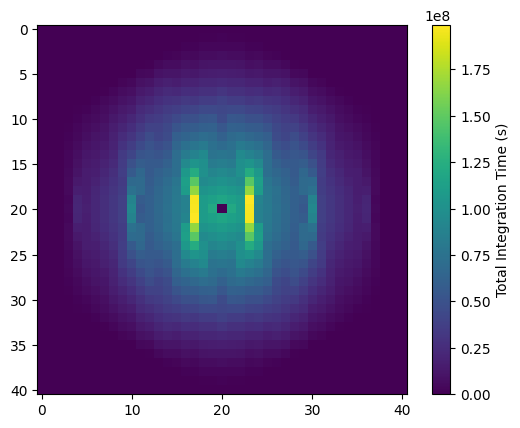

In [40]:
plt.imshow(observation.total_integration_time.value)
ax = plt.colorbar()
ax.set_label('Total Integration Time (s)')


Similarly, we can calculate the thermal noise (in temperature units) for every cell (before the conversion of point 4 above):

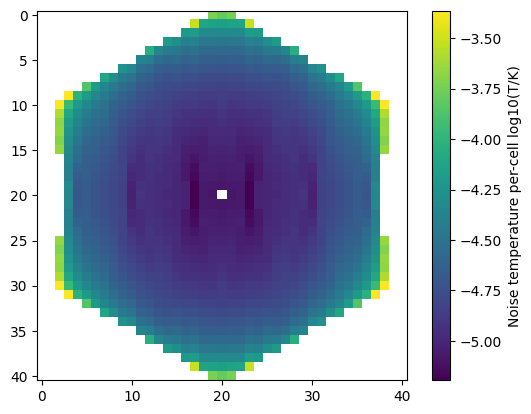

In [41]:
plt.imshow(np.log10(observation.Trms.value))
ax = plt.colorbar()
ax.set_label("Noise temperature per-cell log10(T/K)")

# 6. Associate Cosmological Scales¶
We have a grid of \(uv\eta\). We now convert these to \(k_\perp\) and \(k_{||}\) respectively. Note that these conversions depend slightly on redshift, but typically the range of redshifts under evaluation is so small that a linear conversion is appropriate:

In [42]:
observation.kparallel

<Quantity [ 0.        ,  0.06738094,  0.13476189,  0.20214283,  0.26952378,
            0.33690472,  0.40428566,  0.47166661,  0.53904755,  0.60642849,
            0.67380944,  0.74119038,  0.80857133,  0.87595227,  0.94333321,
            1.01071416,  1.0780951 ,  1.14547605,  1.21285699,  1.28023793,
            1.34761888,  1.41499982,  1.48238076,  1.54976171,  1.61714265,
            1.6845236 ,  1.75190454,  1.81928548,  1.88666643,  1.95404737,
            2.02142832,  2.08880926,  2.1561902 ,  2.22357115,  2.29095209,
            2.35833303,  2.42571398,  2.49309492,  2.56047587,  2.62785681,
           -2.69523775, -2.62785681, -2.56047587, -2.49309492, -2.42571398,
           -2.35833303, -2.29095209, -2.22357115, -2.1561902 , -2.08880926,
           -2.02142832, -1.95404737, -1.88666643, -1.81928548, -1.75190454,
           -1.6845236 , -1.61714265, -1.54976171, -1.48238076, -1.41499982,
           -1.34761888, -1.28023793, -1.21285699, -1.14547605, -1.0780951 ,
           -

In [43]:
observation.ugrid * p21s.conversions.dk_du(observation.redshift)

<Quantity [-0.14008161, -0.13307753, -0.12607344, -0.11906936, -0.11206528,
           -0.1050612 , -0.09805712, -0.09105304, -0.08404896, -0.07704488,
           -0.0700408 , -0.06303672, -0.05603264, -0.04902856, -0.04202448,
           -0.0350204 , -0.02801632, -0.02101224, -0.01400816, -0.00700408,
            0.        ,  0.00700408,  0.01400816,  0.02101224,  0.02801632,
            0.0350204 ,  0.04202448,  0.04902856,  0.05603264,  0.06303672,
            0.0700408 ,  0.07704488,  0.08404896,  0.09105304,  0.09805712,
            0.1050612 ,  0.11206528,  0.11906936,  0.12607344,  0.13307753,
            0.14008161] littleh / Mpc>

# 7. Add Cosmic Variance¶
Cosmic variance comes from the fact that measuring the power spectrum in a finite volume of the Universe doesn’t necessarily reveal the true underlying power spectrum of the Universe – its a random realization of the power. You can show that the uncertainty on the power is proportional to the power itself. Since it’s independent of the thermal noise, it just gets added in quadrature.

To obtain this quantity requires having some model of the power spectrum itself. In-built into 21cmSense is a fiducial 21cmFAST model:

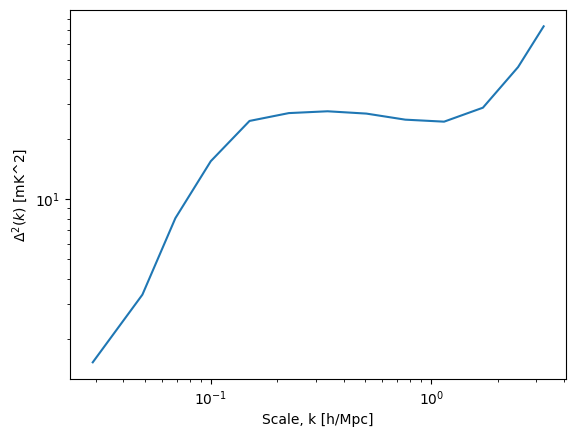

In [44]:
plt.plot(sensitivity.k_21, sensitivity.delta_21)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Scale, k [h/Mpc]")
plt.ylabel("$\Delta^2(k)$ [mK^2]");

# 8. Add Everything Together¶
Now, there’s a few things we need to add together at this stage. What we have effectively is a thermal noise per cell of \(uv\eta\) (corresponding to 3D k-space), and a cosmic variance for each cell.

What we want in the end is the thermal noise in a bin of spherically-averaged \(k\). We’ll first do a cylindrical average, averaging in the \(\mathbf{k}_\perp\) plane:

In [45]:
sense_2d = sensitivity.calculate_sensitivity_2d()

calculating 2D sensitivity: 100%|████████████████████████████████████████████████████████████████████████| 563/563 [00:00<00:00, 694.43uv-bins/s]


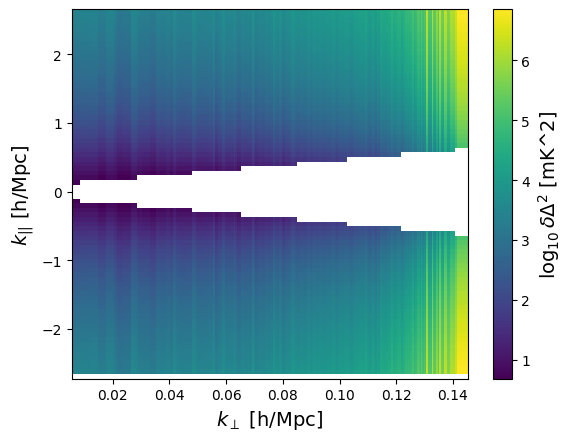

In [46]:
sensitivity.plot_sense_2d(sense_2d)

The big white part here is the “foreground wedge”, where we assume we’ll never take observations (the uncertainty there is infinite). We can modify its extent when creating the sensitivity:

In [47]:
sensitivity = p21s.PowerSpectrum(
    observation=observation,
    foreground_model='optimistic'
)

In [48]:
sense_2d_opt = sensitivity.calculate_sensitivity_2d()

calculating 2D sensitivity: 100%|████████████████████████████████████████████████████████████████████████| 563/563 [00:00<00:00, 667.34uv-bins/s]


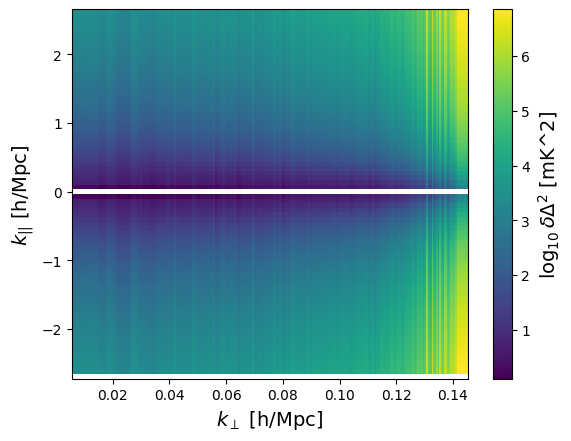

In [49]:
sensitivity.plot_sense_2d(sense_2d_opt)

Finally, we average over circular shells in the 2D plot. We can do this for just thermal, just cosmic variance, or both:

In [50]:
sense_1d_both = sensitivity.calculate_sensitivity_1d()
sense_1d_sample = sensitivity.calculate_sensitivity_1d(thermal=False)
sense_1d_thermal = sensitivity.calculate_sensitivity_1d(sample=False)

The maximum k value is being restricted by the theoretical signal model. Losing ~31 bins.
averaging to 1D: 100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 6215.72kperp-bins/s]


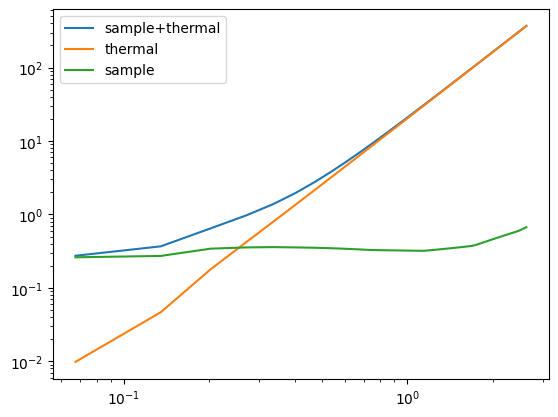

In [51]:
plt.plot(sensitivity.k1d, sense_1d_both, label='sample+thermal')
plt.plot(sensitivity.k1d, sense_1d_thermal, label='thermal')
plt.plot(sensitivity.k1d, sense_1d_sample, label='sample')
plt.legend()

plt.xscale('log')
plt.yscale('log')